# 📚 Watch Brand Classification Project

In [1]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import cv2


2025-05-27 11:07:02.357099: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 11:07:02.358458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 11:07:02.364093: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 11:07:02.372859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748344022.389751   25550 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748344022.39

In [2]:
# 📂 Load and clean metadata
df = pd.read_csv("metadata.csv")
df = df[df["image_name"].apply(lambda x: os.path.exists(os.path.join("images", x)))]

# Remove rare brands (fewer than 2 images)
brand_counts = df["brand"].value_counts()
valid_brands = brand_counts[brand_counts >= 2].index
df = df[df["brand"].isin(valid_brands)].reset_index(drop=True)

# Encode labels
le = LabelEncoder()
df["brand_encoded"] = le.fit_transform(df["brand"])


In [3]:
# 🔀 Split into train and validation sets
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["brand_encoded"], random_state=42
)

# Save for reuse
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)


In [4]:
# 📊 Recalculate number of classes
num_classes = train_df["brand_encoded"].nunique()
print(f"✅ Number of classes: {num_classes}")


✅ Number of classes: 64


In [5]:
# 🧱 Image generator using OpenCV
class ImageDataGenerator(Sequence):
    def __init__(self, df, image_folder, batch_size=32, img_size=(128, 128)):
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.labels = df['brand_encoded'].values
        self.image_names = df['image_name'].values

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_names[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        images = []
        for img_name in batch_images:
            img_path = os.path.join(self.image_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, self.img_size) / 255.0
                images.append(img)

        images = np.array(images)
        labels = to_categorical(batch_labels[:len(images)], num_classes=num_classes)
        return images, labels


In [6]:
# 🔄 Initialize generators
train_gen = ImageDataGenerator(train_df, image_folder="images")
val_gen = ImageDataGenerator(val_df, image_folder="images")


In [7]:
# 🧠 Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-27 11:07:24.564514: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# 🚂 Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.0581 - loss: 4.1632 - val_accuracy: 0.2294 - val_loss: 3.2000
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.2512 - loss: 3.1226 - val_accuracy: 0.4686 - val_loss: 2.4373
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.4023 - loss: 2.4603 - val_accuracy: 0.5255 - val_loss: 1.9839
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.4730 - loss: 2.0762 - val_accuracy: 0.6275 - val_loss: 1.6231
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.5760 - loss: 1.5970 - val_accuracy: 0.6451 - val_loss: 1.4756
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - accuracy: 0.5919 - loss: 1.4490 - val_accuracy: 0.6863 - val_loss: 1.2986
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 277ms/step - accuracy: 0.6632 - loss: 1.1770 - val_accuracy: 0.7314 - val_loss: 1.1804
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.6677 - loss: 1.1425 - val_accuracy: 0.727

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7693 - loss: 1.0565
Validation Accuracy: 75.29%


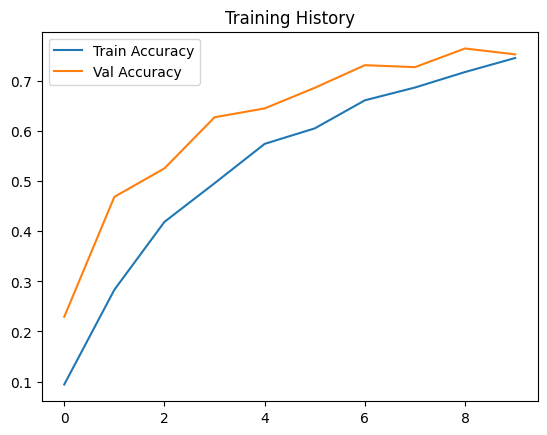

In [9]:
# 📈 Evaluate and plot accuracy
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc:.2%}")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training History")
plt.show()
